In [30]:
# Import the relevant modules to be used later
from __future__ import print_function
import gzip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import struct
import sys
import sys
import time
import seaborn
from tqdm import tqdm
import cv2

try: 
    from urllib.request import urlretrieve 
except ImportError: 
    from urllib import urlretrieve

# Config matplotlib for inline plotting
%matplotlib inline

In [31]:
import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

In [35]:
# Functions to load MNIST images and unpack into train and test set.

def loadData(url):
    #Load the training images
    from PIL import Image, ImageOps

    import glob
    image_list = []
    for filename in glob.glob(url):
        im=Image.open(filename)
        im_numpy = np.array(im)
        image_list.append(im_numpy.flatten())
        im.close()
    return image_list

def loadLabels(url):
    import pandas as pd

    labels = pd.read_csv(url)

    labels = labels['orientation']
    lbs = np.array(labels).reshape(labels.shape[0], 1)
    return lbs

def try_download(dataSrc, labelsSrc):
    data = loadData(dataSrc)
    labels = loadLabels(labelsSrc)
    return np.hstack((data, labels))


In [4]:
# URLs for the train image and labels data
url_train_image = 'C:/data-release/train-images/*.png'
url_train_labels = 'C:/data-release/train_label.csv'
num_train_samples = 20000

print("Downloading train data")
train = try_download(url_train_image, url_train_labels)


url_test_image = 'C:/data-release/test-images/*.png'
url_test_labels = url_train_labels
num_test_samples = 20000

print("Downloading test data")
test = try_download(url_test_image, url_test_labels)

Image Label:  1


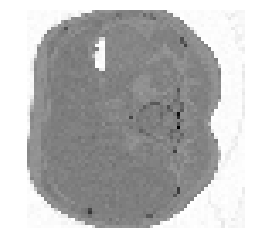

In [5]:
# Plot a random image
sample_number = 0
plt.imshow(train[sample_number,:-1].reshape(64,64), cmap="gray_r")
plt.axis('off')
print("Image Label: ", train[sample_number,-1])

In [36]:
# Save the data files into a format compatible with CNTK text reader
def savetxt(filename, ndarray):
    dir = os.path.dirname(filename)

    if not os.path.exists(dir):
        os.makedirs(dir)

    if not os.path.isfile(filename):
        print("Saving", filename )
        with open(filename, 'w') as f:
            labels = list(map(' '.join, np.eye(4, dtype=np.uint).astype(str)))
            for row in ndarray:
                row_str = row.astype(str)
                label_str = labels[row[-1]]
                feature_str = ' '.join(row_str[:-1])
                f.write('|labels {} |features {}\n'.format(label_str, feature_str))
    else:
        print("File already exists", filename)

In [7]:
# Save the train and test files (prefer our default path for the data)
data_dir = "C:/data-release/CNTK/"
if not os.path.exists(data_dir):
    data_dir = os.path.join("data", "MNIST")

print ('Writing train text file...')
savetxt(os.path.join(data_dir, "Train-64x64_cntk_text.txt"), train)

print ('Writing test text file...')
savetxt(os.path.join(data_dir, "Test-64x64_cntk_text.txt"), test)

print('Done')

Writing train text file...
File already exists C:/Users/ejiof/Documents/data-release/CNTK/Train-64x64_cntk_text.txt
Writing test text file...
Saving C:/Users/ejiof/Documents/data-release/CNTK/Test-64x64_cntk_text.txt
Done


In [37]:
# Define the data dimensions
input_dim_model = (1, 64, 64)    # images are 64 x 64 with 1 channel of color (gray)
input_dim = 64*64               # used by readers to treat input data as a vector
num_output_classes = 4

In [38]:
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):

    ctf = C.io.CTFDeserializer(path, C.io.StreamDefs(
          labels=C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
          features=C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)))

    return C.io.MinibatchSource(ctf,
        randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [74]:
# Ensure the training and test data is available for this tutorial.

data_found=False # A flag to indicate if train/test data found in local cache
data_dir = "C:/data-release/CNTK/"

train_file=os.path.join(data_dir, "Train-64x64_cntk_text.txt")
test_file=os.path.join(data_dir, "Test-64x64_cntk_text.txt")

if os.path.isfile(train_file) and os.path.isfile(test_file):
    data_found=True


if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")

print("Data directory is {0}".format(data_dir))

Data directory is C:/Users/ejiof/Documents/data-release/CNTK/


In [40]:
x = C.input_variable(input_dim_model)
y = C.input_variable(num_output_classes)

In [41]:
reader_train = create_reader(train_file, True, input_dim, num_output_classes)
reader_test = create_reader(test_file, False, input_dim, num_output_classes)

In [42]:
from cntk import load_model
from cntk.initializer import he_normal, normal
from cntk.layers import AveragePooling, MaxPooling, BatchNormalization, Convolution, Dense
from cntk.ops import element_times, relu
#
# For Training
from cntk import cross_entropy_with_softmax, classification_error, reduce_mean
from cntk import Trainer, cntk_py
from cntk.io import MinibatchSource, ImageDeserializer, StreamDef, StreamDefs
from cntk.learners import momentum_sgd, momentum_schedule,  learning_parameter_schedule_per_sample
from cntk.debugging import *
from cntk.logging import *
import cntk.io.transforms as xforms

In [43]:
try:
    isUsingGPU # if this is our first time running, this will cause an exception as undefined
except NameError:
    try:
        isUsingGPU = C.device.try_set_default_device(C.device.gpu(0))
    except ValueError:
        isUsingGPU = False
        C.device.try_set_default_device(C.device.cpu())

print ("The Cognitive Toolkit is using the {} for processing.".format("GPU" if isUsingGPU else "CPU"))

The Cognitive Toolkit is using the CPU for processing.


In [44]:
def conv_bn(input, filter_size, num_filters, strides=(1, 1), init=he_normal(), bn_init_scale=1):
    c = Convolution(filter_size, num_filters, activation=None, init=init, pad=True, strides=strides, bias=False)(input)
    r = BatchNormalization(map_rank=1, normalization_time_constant=4096, use_cntk_engine=False, init_scale=bn_init_scale, disable_regularization=True)(c)
    return r

def conv_bn_relu(input, filter_size, num_filters, strides=(1, 1), init=he_normal()):
    r = conv_bn(input, filter_size, num_filters, strides, init, 1)
    return relu(r)

In [45]:
def resnet_basic(input, num_filters):
    c1 = conv_bn_relu(input, (3, 3), num_filters)
    c2 = conv_bn(c1, (3, 3), num_filters, bn_init_scale=1)
    p = c2 + input
    return relu(p)

def resnet_basic_inc(input, num_filters, strides=(2, 2)):
    c1 = conv_bn_relu(input, (3, 3), num_filters, strides)
    c2 = conv_bn(c1, (3, 3), num_filters, bn_init_scale=1)
    s = conv_bn(input, (1, 1), num_filters, strides) # Shortcut
    p = c2 + s
    return relu(p)

In [46]:
def resnet_basic_stack(input, num_stack_layers, num_filters): 
    assert(num_stack_layers >= 0)
    l = input
    for _ in range(num_stack_layers):
        l = resnet_basic(l, num_filters)
    return l

def resnet_bottleneck(input, out_num_filters, inter_out_num_filters):
    c1 = conv_bn_relu(input, (1, 1), inter_out_num_filters)
    c2 = conv_bn_relu(c1, (3, 3), inter_out_num_filters)
    c3 = conv_bn(c2, (1, 1), out_num_filters, bn_init_scale=0)
    p = c3 + input
    return relu(p)

def resnet_bottleneck_inc(input, out_num_filters, inter_out_num_filters, stride1x1, stride3x3):
    c1 = conv_bn_relu(input, (1, 1), inter_out_num_filters, strides=stride1x1)
    c2 = conv_bn_relu(c1, (3, 3), inter_out_num_filters, strides=stride3x3)
    c3 = conv_bn(c2, (1, 1), out_num_filters, bn_init_scale=0)
    stride = np.multiply(stride1x1, stride3x3)
    s = conv_bn(input, (1, 1), out_num_filters, strides=stride) # Shortcut
    p = c3 + s
    return relu(p)

def resnet_bottleneck_stack(input, num_stack_layers, out_num_filters, inter_out_num_filters): 
    assert(num_stack_layers >= 0)
    l = input
    for _ in range(num_stack_layers):
        l = resnet_bottleneck(l, out_num_filters, inter_out_num_filters)
    return l

In [47]:
def create_cifar10_model(input, num_stack_layers, num_classes):
    c_map = [16, 32, 64]

    conv = conv_bn_relu(input, (3, 3), c_map[0])
    r1 = resnet_basic_stack(conv, num_stack_layers, c_map[0])

    r2_1 = resnet_basic_inc(r1, c_map[1])
    r2_2 = resnet_basic_stack(r2_1, num_stack_layers-1, c_map[1])

    r3_1 = resnet_basic_inc(r2_2, c_map[2])
    r3_2 = resnet_basic_stack(r3_1, num_stack_layers-1, c_map[2])

    # Global average pooling and output
    pool = AveragePooling(filter_shape=(8, 8), name='final_avg_pooling')(r3_2)
    z = Dense(num_classes, init=normal(0.01))(pool)
    return z

In [48]:
make_model = True

In [49]:
# model dimensions
image_height = 64
image_width  = 64
num_channels = 1 # RGB
num_classes  = 4



# Input variables denoting the features and label data
input_var = C.input_variable((num_channels, image_height, image_width), name='features')
label_var = C.input_variable((num_classes))

#input1_node = trained_model.find_by_name('input_var')
#input2_node = trained_model.find_by_name('label_var')


# create model, and configure learning parameters - ResNet20
#trained_model = load_model(os.path.join(model_dir, model_file))
resnet20_cifar10_model1 = create_cifar10_model(input_var, 3, num_classes)
#resnet20_cifar10_model1 = trained_model.clone(C.CloneMethod.clone, {input1_node: input_var, input2_node: label_var}) 


# loss and metric
ce = cross_entropy_with_softmax(resnet20_cifar10_model1, label_var)
pe = classification_error(resnet20_cifar10_model1, label_var)

In [50]:
epoch_size = 20000  # number of training examples ...
minibatch_size = 128 # examples per mini-batch for training

if isUsingGPU:
    epochs = 44
else:
    # these are the settings for CPU-only / Azure Notebooks
    # if you have time/patience, consider changing the number of epochs from 1 to 5 and running again
    epochs = 48
    if make_model:
        print("We're not using a GPU, so we're going to restrict our training for time reasons.")
        print("We'll be training for {} epoch with a training set of {} elements".format(epochs, epoch_size))
        
model_dir = 'C:/data-release/Model/'
if not model_dir:
    model_dir = os.path.join(abs_path, "Models")

We're not using a GPU, so we're going to restrict our training for time reasons.
We'll be training for 48 epoch with a training set of 20000 elements


In [51]:
# Train and evaluate the network.
def train_and_evaluate(reader_train, reader_test, epoch_size, max_epochs, profiler_dir=None,
                       model_dir=None, log_dir=None, tensorboard_logdir=None, gen_heartbeat=False):

    set_computation_network_trace_level(0)

    # shared training parameters
    l2_reg_weight = 0.0001

    # Set learning parameters
    lr_per_mb = [1.0]*80 + [0.1]*40 + [0.01]
    lr_per_sample = [lr/minibatch_size for lr in lr_per_mb]
    lr_schedule = learning_parameter_schedule_per_sample(lr_per_sample)
    mm_schedule = momentum_schedule(0.9, minibatch_size)

    # progress writers
    progress_writers = [ProgressPrinter(tag='Training', log_to_file=log_dir, gen_heartbeat=gen_heartbeat)] 

    # trainer object
    learner = momentum_sgd(resnet20_cifar10_model1.parameters, lr_schedule, mm_schedule,
                           l2_regularization_weight=l2_reg_weight)
    trainer = Trainer(resnet20_cifar10_model1, (ce, pe), learner, progress_writers)

    # define mapping from reader streams to network inputs
    input_map = {
        input_var: reader_train.streams.features,
        label_var: reader_train.streams.labels
    }

    # perform model training
    print('[i] Performing training...')
    for epoch in range(max_epochs): # loop over epochs
        print('[i] Processing epoch {}'.format(epoch),flush=True)
        sample_count = 0
        pbar = tqdm(total=epoch_size, ascii=True)
        while sample_count < epoch_size:  # loop over minibatches in the epoch
            current_minibatch_size = min(minibatch_size, epoch_size-sample_count)
            data = reader_train.next_minibatch(current_minibatch_size, input_map=input_map) # fetch minibatch.
            trainer.train_minibatch(data)                  # update model with it
            sample_count += current_minibatch_size         # count samples processed so far
            pbar.update(current_minibatch_size)
        pbar.close()

        trainer.summarize_training_progress()

        if model_dir:
            resnet20_cifar10_model1.save(os.path.join(model_dir, network_name + "_{}.dnn".format(epoch)))

    # Evaluation parameters
    test_epoch_size = 20000
    test_minibatch_size = 16

    # process minibatches and evaluate the model
    metric_numer = 0
    metric_denom = 0
    sample_count = 0

    print('[i] Evaluating model...', flush=True)
    pbar = tqdm(total=test_epoch_size, ascii=True)
    while sample_count < test_epoch_size:
        current_minibatch_size = min(test_minibatch_size, test_epoch_size - sample_count)
        # Fetch next test min batch.
        data = reader_test.next_minibatch(current_minibatch_size, input_map=input_map)
        # minibatch data to be trained with
        metric_numer += trainer.test_minibatch(data) * current_minibatch_size
        metric_denom += current_minibatch_size
        # Keep track of the number of samples processed so far.
        sample_count += data[label_var].num_samples
        pbar.update(current_minibatch_size)
    pbar.close()

    print("")
    trainer.summarize_test_progress()
    print("")

    return resnet20_cifar10_model1


In [52]:
if make_model:
    model_file = 'LocallyTrained_ResNet_20_Medical1_CNTK.model'
    print("make_model is true, so performing training...")
    print("Creating minibatch source for training...", flush=True)
    reader_train = create_reader(train_file, True, input_dim, num_output_classes)
    print("Creating minibatch source for testing...", flush=True)
    reader_test = create_reader(train_file, True, input_dim, num_output_classes)

    startTime = time.time()
    trained_model = train_and_evaluate(reader_train, reader_test, epoch_size, epochs)
    endTime = time.time()
    
    print("The model took {:.4f} seconds to train".format(endTime - startTime))
    print("Saving the model as >>{}<<".format(model_file))
    
    resnet20_cifar10_model1.save(os.path.join(model_dir, model_file))
else:
    model_file = 'ResNet_20_CIFAR10_CNTK.model'
    print("make_model is false, so skipping training...")

make_model is true, so performing training...
Creating minibatch source for training...
Creating minibatch source for testing...


C:\Users\ejiof\Anaconda3\lib\site-packages\cntk\learners\__init__.py:340: RuntimeWarning: When providing the schedule as a number, epoch_size is ignored
  warnings.warn('When providing the schedule as a number, epoch_size is ignored', RuntimeWarning)


[i] Performing training...
[i] Processing epoch 0


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning rate per 1 samples: 0.0078125
Momentum per minibatch: 0.9


100%|##########| 20000/20000 [18:39<00:00, 19.11it/s]


Finished Epoch[1]: [Training] loss = 3.304870 * 20000, metric = 54.45% * 20000 1119.788s ( 17.9 samples/s);
[i] Processing epoch 1


100%|##########| 20000/20000 [16:12<00:00, 19.30it/s]


Finished Epoch[2]: [Training] loss = 0.944120 * 20000, metric = 40.14% * 20000 972.682s ( 20.6 samples/s);
[i] Processing epoch 2


100%|##########| 20000/20000 [16:16<00:00, 19.20it/s]


Finished Epoch[3]: [Training] loss = 0.891184 * 20000, metric = 35.67% * 20000 976.639s ( 20.5 samples/s);
[i] Processing epoch 3


100%|##########| 20000/20000 [16:09<00:00, 18.86it/s]


Finished Epoch[4]: [Training] loss = 0.915902 * 20000, metric = 35.78% * 20000 969.999s ( 20.6 samples/s);
[i] Processing epoch 4


100%|##########| 20000/20000 [16:14<00:00, 18.32it/s]


Finished Epoch[5]: [Training] loss = 0.807554 * 20000, metric = 29.75% * 20000 974.512s ( 20.5 samples/s);
[i] Processing epoch 5


100%|##########| 20000/20000 [16:06<00:00, 17.49it/s]


Finished Epoch[6]: [Training] loss = 0.701453 * 20000, metric = 23.76% * 20000 966.124s ( 20.7 samples/s);
[i] Processing epoch 6


100%|##########| 20000/20000 [16:05<00:00, 19.67it/s]


Finished Epoch[7]: [Training] loss = 0.499696 * 20000, metric = 17.20% * 20000 965.308s ( 20.7 samples/s);
[i] Processing epoch 7


100%|##########| 20000/20000 [16:03<00:00, 19.30it/s]


Finished Epoch[8]: [Training] loss = 0.401092 * 20000, metric = 13.64% * 20000 963.582s ( 20.8 samples/s);
[i] Processing epoch 8


100%|##########| 20000/20000 [16:06<00:00, 18.31it/s]


Finished Epoch[9]: [Training] loss = 0.313386 * 20000, metric = 10.66% * 20000 966.342s ( 20.7 samples/s);
[i] Processing epoch 9


100%|##########| 20000/20000 [17:22<00:00, 18.33it/s]


Finished Epoch[10]: [Training] loss = 0.236800 * 20000, metric = 8.19% * 20000 1042.891s ( 19.2 samples/s);
[i] Processing epoch 10


100%|##########| 20000/20000 [18:25<00:00, 11.13it/s]


Finished Epoch[11]: [Training] loss = 0.191680 * 20000, metric = 6.26% * 20000 1106.141s ( 18.1 samples/s);
[i] Processing epoch 11


100%|##########| 20000/20000 [17:18<00:00, 19.05it/s]


Finished Epoch[12]: [Training] loss = 0.144052 * 20000, metric = 4.42% * 20000 1038.682s ( 19.3 samples/s);
[i] Processing epoch 12


100%|##########| 20000/20000 [16:55<00:00, 17.11it/s]


Finished Epoch[13]: [Training] loss = 0.122218 * 20000, metric = 3.90% * 20000 1015.308s ( 19.7 samples/s);
[i] Processing epoch 13


100%|##########| 20000/20000 [16:48<00:00, 18.47it/s]


Finished Epoch[14]: [Training] loss = 0.084703 * 20000, metric = 2.69% * 20000 1008.337s ( 19.8 samples/s);
[i] Processing epoch 14


100%|##########| 20000/20000 [16:35<00:00, 17.96it/s]


Finished Epoch[15]: [Training] loss = 0.063654 * 20000, metric = 2.04% * 20000 995.062s ( 20.1 samples/s);
[i] Processing epoch 15


100%|##########| 20000/20000 [16:38<00:00, 18.80it/s]


Finished Epoch[16]: [Training] loss = 0.045593 * 20000, metric = 1.43% * 20000 998.394s ( 20.0 samples/s);
[i] Processing epoch 16


100%|##########| 20000/20000 [16:37<00:00, 17.75it/s]


Finished Epoch[17]: [Training] loss = 0.045774 * 20000, metric = 1.35% * 20000 997.245s ( 20.1 samples/s);
[i] Processing epoch 17


100%|##########| 20000/20000 [16:17<00:00, 18.96it/s]


Finished Epoch[18]: [Training] loss = 0.043561 * 20000, metric = 1.24% * 20000 977.414s ( 20.5 samples/s);
[i] Processing epoch 18


100%|##########| 20000/20000 [16:13<00:00, 18.93it/s]


Finished Epoch[19]: [Training] loss = 0.029084 * 20000, metric = 0.91% * 20000 973.143s ( 20.6 samples/s);
[i] Processing epoch 19


100%|##########| 20000/20000 [16:24<00:00, 18.93it/s]


Finished Epoch[20]: [Training] loss = 0.025283 * 20000, metric = 0.79% * 20000 985.000s ( 20.3 samples/s);
[i] Processing epoch 20


100%|##########| 20000/20000 [16:34<00:00, 19.81it/s]


Finished Epoch[21]: [Training] loss = 0.021067 * 20000, metric = 0.64% * 20000 994.119s ( 20.1 samples/s);
[i] Processing epoch 21


100%|##########| 20000/20000 [15:59<00:00, 19.68it/s]


Finished Epoch[22]: [Training] loss = 0.021629 * 20000, metric = 0.68% * 20000 959.266s ( 20.8 samples/s);
[i] Processing epoch 22


100%|##########| 20000/20000 [15:58<00:00, 19.66it/s]


Finished Epoch[23]: [Training] loss = 0.021561 * 20000, metric = 0.67% * 20000 958.456s ( 20.9 samples/s);
[i] Processing epoch 23


100%|##########| 20000/20000 [16:18<00:00, 19.01it/s]


Finished Epoch[24]: [Training] loss = 0.019305 * 20000, metric = 0.53% * 20000 978.108s ( 20.4 samples/s);
[i] Processing epoch 24


100%|##########| 20000/20000 [16:04<00:00, 19.94it/s]


Finished Epoch[25]: [Training] loss = 0.016206 * 20000, metric = 0.46% * 20000 964.721s ( 20.7 samples/s);
[i] Processing epoch 25


100%|##########| 20000/20000 [16:03<00:00, 19.06it/s]


Finished Epoch[26]: [Training] loss = 0.015356 * 20000, metric = 0.44% * 20000 963.838s ( 20.8 samples/s);
[i] Processing epoch 26


100%|##########| 20000/20000 [16:04<00:00, 18.69it/s]


Finished Epoch[27]: [Training] loss = 0.021184 * 20000, metric = 0.66% * 20000 964.154s ( 20.7 samples/s);
[i] Processing epoch 27


100%|##########| 20000/20000 [15:59<00:00, 18.32it/s]


Finished Epoch[28]: [Training] loss = 0.010310 * 20000, metric = 0.34% * 20000 959.932s ( 20.8 samples/s);
[i] Processing epoch 28


100%|##########| 20000/20000 [16:08<00:00, 19.25it/s]


Finished Epoch[29]: [Training] loss = 0.010731 * 20000, metric = 0.33% * 20000 962.041s ( 20.8 samples/s);
[i] Processing epoch 29


100%|##########| 20000/20000 [16:00<00:00, 19.60it/s]


Finished Epoch[30]: [Training] loss = 0.007968 * 20000, metric = 0.25% * 20000 960.608s ( 20.8 samples/s);
[i] Processing epoch 30


100%|##########| 20000/20000 [15:57<00:00, 18.82it/s]


Finished Epoch[31]: [Training] loss = 0.017307 * 20000, metric = 0.47% * 20000 957.727s ( 20.9 samples/s);
[i] Processing epoch 31


100%|##########| 20000/20000 [16:19<00:00, 18.93it/s]


Finished Epoch[32]: [Training] loss = 0.045320 * 20000, metric = 1.27% * 20000 979.353s ( 20.4 samples/s);
[i] Processing epoch 32


100%|##########| 20000/20000 [16:05<00:00, 18.81it/s]


Finished Epoch[33]: [Training] loss = 0.026037 * 20000, metric = 0.75% * 20000 965.188s ( 20.7 samples/s);
[i] Processing epoch 33


100%|##########| 20000/20000 [16:03<00:00, 16.97it/s]


Finished Epoch[34]: [Training] loss = 0.015896 * 20000, metric = 0.42% * 20000 963.470s ( 20.8 samples/s);
[i] Processing epoch 34


100%|##########| 20000/20000 [16:01<00:00, 19.42it/s]


Finished Epoch[35]: [Training] loss = 0.013974 * 20000, metric = 0.40% * 20000 961.123s ( 20.8 samples/s);
[i] Processing epoch 35


100%|##########| 20000/20000 [16:07<00:00, 19.59it/s]


Finished Epoch[36]: [Training] loss = 0.010576 * 20000, metric = 0.28% * 20000 967.900s ( 20.7 samples/s);
[i] Processing epoch 36


100%|##########| 20000/20000 [16:02<00:00, 19.63it/s]


Finished Epoch[37]: [Training] loss = 0.009703 * 20000, metric = 0.27% * 20000 962.307s ( 20.8 samples/s);
[i] Processing epoch 37


100%|##########| 20000/20000 [15:59<00:00, 19.77it/s]


Finished Epoch[38]: [Training] loss = 0.007633 * 20000, metric = 0.24% * 20000 959.497s ( 20.8 samples/s);
[i] Processing epoch 38


100%|##########| 20000/20000 [15:58<00:00, 19.19it/s]


Finished Epoch[39]: [Training] loss = 0.009002 * 20000, metric = 0.28% * 20000 958.872s ( 20.9 samples/s);
[i] Processing epoch 39


100%|##########| 20000/20000 [16:01<00:00, 19.89it/s]


Finished Epoch[40]: [Training] loss = 0.014819 * 20000, metric = 0.44% * 20000 962.000s ( 20.8 samples/s);
[i] Processing epoch 40


100%|##########| 20000/20000 [16:01<00:00, 18.57it/s]


Finished Epoch[41]: [Training] loss = 0.008327 * 20000, metric = 0.18% * 20000 961.185s ( 20.8 samples/s);
[i] Processing epoch 41


100%|##########| 20000/20000 [16:03<00:00, 16.97it/s]


Finished Epoch[42]: [Training] loss = 0.005921 * 20000, metric = 0.18% * 20000 963.274s ( 20.8 samples/s);
[i] Processing epoch 42


100%|##########| 20000/20000 [15:58<00:00, 18.84it/s]


Finished Epoch[43]: [Training] loss = 0.006139 * 20000, metric = 0.19% * 20000 958.238s ( 20.9 samples/s);
[i] Processing epoch 43


100%|##########| 20000/20000 [16:04<00:00, 16.64it/s]


Finished Epoch[44]: [Training] loss = 0.059448 * 20000, metric = 1.49% * 20000 964.332s ( 20.7 samples/s);
[i] Processing epoch 44


100%|##########| 20000/20000 [16:03<00:00, 19.35it/s]


Finished Epoch[45]: [Training] loss = 0.023994 * 20000, metric = 0.73% * 20000 963.566s ( 20.8 samples/s);
[i] Processing epoch 45


100%|##########| 20000/20000 [16:05<00:00, 19.52it/s]


Finished Epoch[46]: [Training] loss = 0.022491 * 20000, metric = 0.65% * 20000 965.659s ( 20.7 samples/s);
[i] Processing epoch 46


100%|##########| 20000/20000 [15:56<00:00, 19.79it/s]


Finished Epoch[47]: [Training] loss = 0.010763 * 20000, metric = 0.29% * 20000 956.524s ( 20.9 samples/s);
[i] Processing epoch 47


100%|##########| 20000/20000 [16:31<00:00, 17.17it/s]


Finished Epoch[48]: [Training] loss = 0.012536 * 20000, metric = 0.36% * 20000 991.358s ( 20.2 samples/s);
[i] Evaluating model...


100%|##########| 20000/20000 [04:33<00:00, 89.24it/s]



Finished Evaluation [1]: Minibatch[1-1250]: metric = 18.29% * 20000;

The model took 47322.9061 seconds to train
Saving the model as >>LocallyTrained_ResNet_20_Medical1_CNTK.model<<


In [70]:
#resnet20_cifar10_model1.save(os.path.join(model_dir, model_file))
model_dir = 'C:/data-release/Model/'
data_dir = 'C:/data-release/CNTKFormat/'
model_file = 'LocallyTrained_ResNet_20_medical1_CNTK.model'
resnet20_cifar10_model1 = load_model(os.path.join(model_dir, model_file))

In [71]:
out = C.softmax(resnet20_cifar10_model1)

In [72]:
test_file=os.path.join(data_dir, "Test-64x64_cntk_text.txt")

In [ ]:
# Read the data for evaluation
reader_eval=create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 20000
eval_input_map = {x: reader_eval.streams.features, y:reader_eval.streams.labels}

data = reader_eval.next_minibatch(eval_minibatch_size, input_map=eval_input_map)

img_label = data[y].asarray()
img_data = data[x].asarray()

# reshape img_data to: M x 1 x 64 x 64 to be compatible with model
img_data = np.reshape(img_data, (eval_minibatch_size, 1, 64, 64))
#plt.imshow(image_list[1].reshape(64,64))
#img_data = img_data.reshape(64, 64)
#img_data = img_data.reshape((img_data.shape[0],) + input_var.shape[1:])

predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]

In [57]:
pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]

In [58]:
print("Label    :", gtlabel[:35])
print("Predicted:", pred)

Label    : [1, 2, 1, 1, 2, 3, 3, 2, 0, 2, 2, 3, 3, 1, 0, 2, 0, 0, 1, 1, 3, 3, 2, 2, 2, 0, 3, 0, 2, 2, 2, 3, 1, 2, 1]


Predicted: [3, 3, 3, 2, 3, 3, 1, 0, 1, 0, 2, 0, 3, 0, 3, 1, 3, 3, 3, 3, 0, 2, 0, 3, 0, 3, 2, 3, 2, 2, 3, 3, 2, 3, 0, 3, 3, 2, 3, 2, 0, 3, 3, 3, 3, 2, 3, 3, 0, 3, 3, 2, 2, 0, 3, 3, 1, 0, 0, 3, 2, 3, 3, 2, 3, 2, 3, 0, 2, 3, 2, 2, 2, 3, 3, 1, 2, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 0, 2, 3, 3, 0, 2, 3, 0, 3, 3, 2, 0, 2, 3, 3, 3, 2, 3, 3, 3, 1, 3, 1, 0, 2, 0, 0, 3, 2, 3, 3, 0, 2, 1, 1, 2, 3, 2, 3, 0, 3, 3, 2, 1, 0, 1, 2, 3, 2, 2, 3, 2, 2, 0, 2, 3, 3, 3, 1, 3, 0, 1, 3, 3, 0, 3, 0, 2, 0, 2, 2, 0, 3, 0, 2, 2, 3, 3, 3, 3, 3, 3, 3, 1, 1, 2, 3, 2, 3, 3, 1, 3, 2, 0, 2, 3, 1, 0, 2, 2, 3, 1, 3, 2, 1, 0, 3, 0, 3, 1, 3, 2, 3, 0, 0, 1, 1, 2, 2, 0, 0, 3, 0, 0, 3, 0, 0, 3, 3, 2, 3, 3, 2, 0, 0, 0, 1, 2, 2, 3, 3, 3, 2, 0, 3, 0, 3, 3, 3, 1, 3, 3, 1, 0, 3, 1, 3, 2, 3, 3, 1, 0, 0, 3, 3, 1, 3, 3, 0, 1, 3, 3, 0, 2, 3, 2, 3, 1, 3, 0, 1, 1, 2, 3, 2, 1, 3, 2, 0, 3, 1, 3, 3, 3, 3, 3, 0, 2, 3, 3, 3, 1, 0, 1, 2, 3, 3, 2, 3, 1, 2, 3, 3, 3, 0, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 0, 2, 0, 2, 2, 3, 1, 3, 3, 0, 0

Image Label:  3
Image Name:  100002


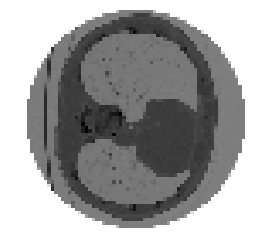

In [59]:
sample_number = 2
plt.imshow(img_data[sample_number].reshape(64,64), cmap="gray_r")
plt.axis('off')

img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)

print("Image Name: ", image_names[sample_number])

In [60]:
pred_ = np.array(pred)
image_names_ = np.array(image_names)

In [61]:
print(pred_.shape)
print(image_names_.shape)

(20000,)
(20000,)


In [62]:
composite = np.column_stack((image_names_, pred_))

In [63]:
print(composite.shape)
print(composite[:,:40])

(20000, 2)
[['100000' '3']
 ['100001' '3']
 ['100002' '3']
 ...
 ['119997' '3']
 ['119998' '0']
 ['119999' '0']]


In [64]:
import pandas as pd
x = pd.DataFrame(composite, columns = ['id','orientation'])

In [65]:
x.to_csv('C:/data-release/Predictions.csv', header = True, index = False)

In [ ]:
#You can save it with the above code or this.
np.savetxt('C:/AIFolder/Submit/AISubmit.csv',  x.astype(int), delimiter=',', header = 'id,orientation')